In [1]:
#import neccessary libraries
from pandas import read_excel
import pandas as pd
from matplotlib import pyplot as plt
# !pip install statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

KeyboardInterrupt: 

In [ ]:
#read in data
gmak = read_excel('tsdata.xlsx', header=0, index_col=0, parse_dates=True, squeeze=True)
gmak.head(10)

/var/folders/7s/j58gn4296fn0f_714k2grx580000gn/T/ipykernel_6349/2053834859.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  gmak = read_excel('data/tsdata.xlsx', header=0, index_col=0, parse_dates=True, squeeze=True)


YearMonth
1980-01-01    188
1980-02-01    140
1980-03-01    188
1980-04-01    209
1980-05-01    234
1980-06-01    272
1980-07-01    400
1980-08-01    408
1980-09-01    314
1980-10-01    236
Name: GMAK, dtype: int64

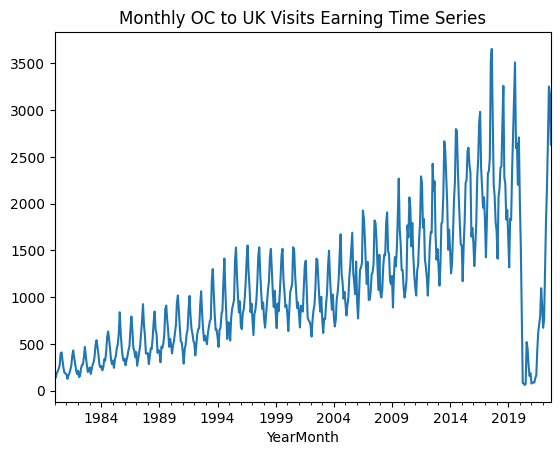

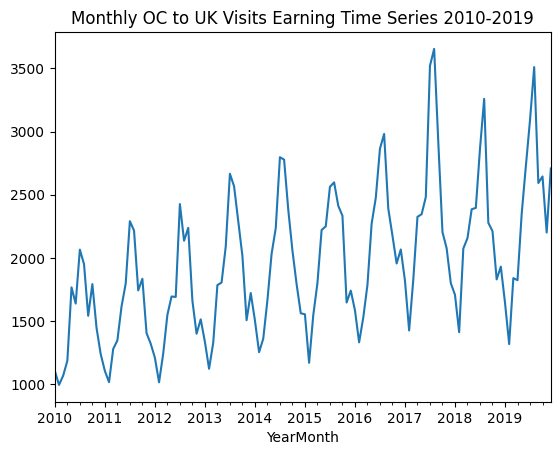

In [3]:
#2.1 data preparation
#plot the data
gmak.plot()
plt.title('Monthly OC to UK Visits Earning Time Series')
plt.show()

#from the plot, we can see that the data is not stationary
#it has seasonality of a high peak in the summer months, and a trend of going up over time except for after 2019 hit by covid 19.
#the variance seems to be not constant over time
#let's take a look at data from 2010-2019 as an example
gmak_2010_2019 = gmak['2010':'2019']
gmak_2010_2019.plot()
plt.title('Monthly OC to UK Visits Earning Time Series 2010-2019')
plt.show()
#we can see that the pattern for seasonality is every 12 months, and the trend is going up over time
#the variance seems to get bigger over time as well.


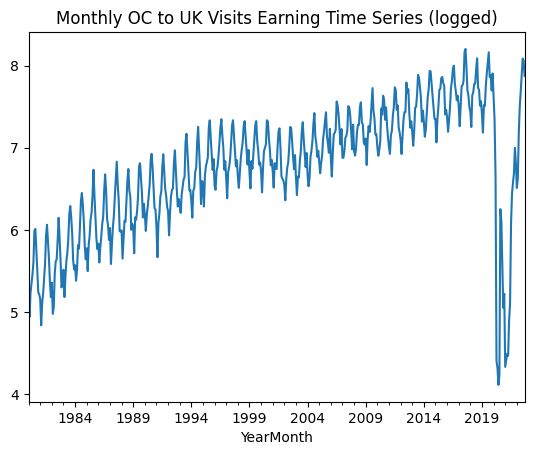

In [4]:
#2.2 preliminary analysis
#thus we need to stable the variance. we can do this by taking the log of the data
gmak_log = np.log(gmak)
#plot the logged gmak
gmak_log.plot()
plt.title('Monthly OC to UK Visits Earning Time Series (logged)')
plt.show()
#seems the same, but the variance is now stable.



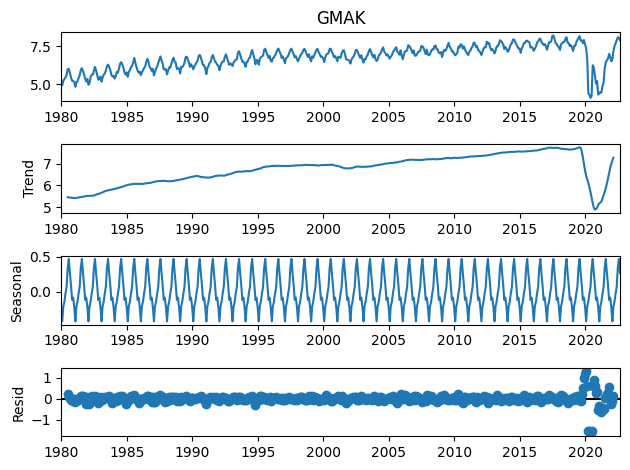

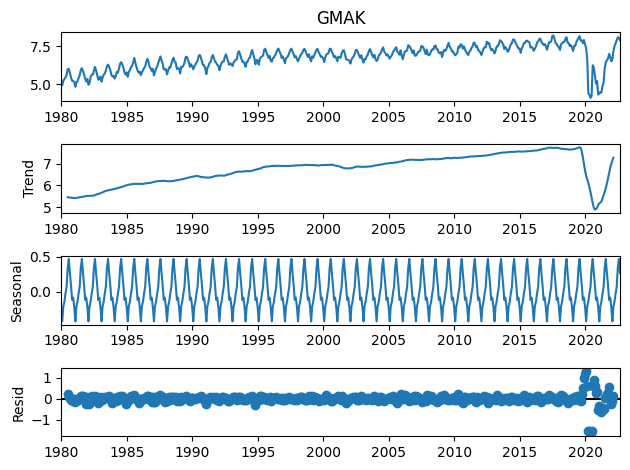

In [5]:
#we will continue to use the stable variance data for the rest of the analysis
#plot time series decomposition

seasonal= seasonal_decompose(gmak_log, model='additive')
seasonal.plot()

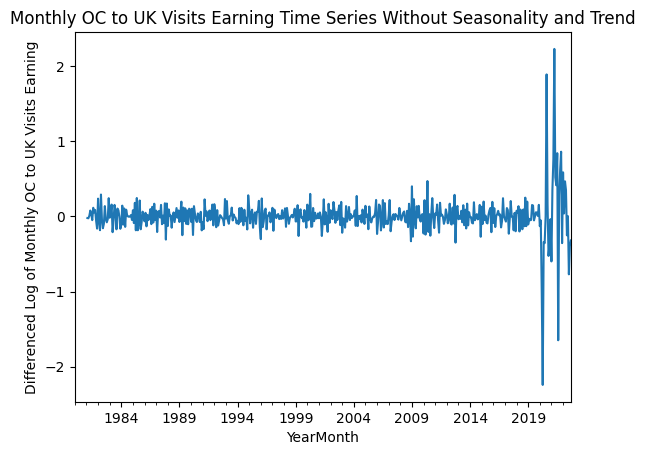

ADF Statistic: -7.238760
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


In [9]:
#2.2 preliminary analysis


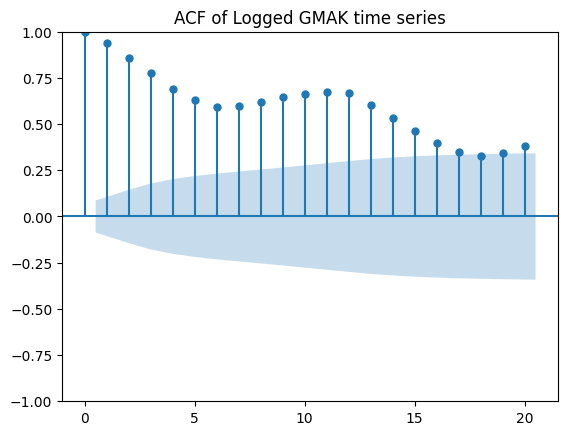

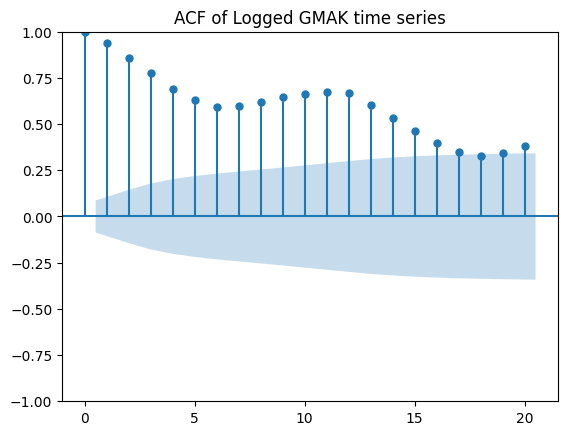

In [6]:
#plot the acf for the original data
#we can see that the autocorrelations do not drop to zero, so the data is not stationary
plot_acf(gmak_log, title='ACF of Logged GMAK time series', lags=20)
#there is no autocorrleation for any lag, and thus for the moving average model, we can set q=0

/Users/zhengzeng/.pyenv/versions/3.9.4/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


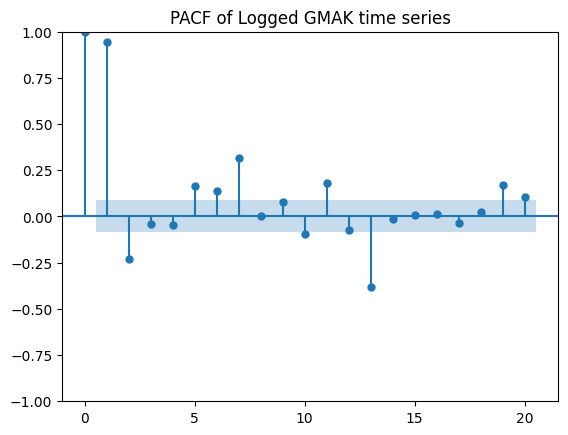

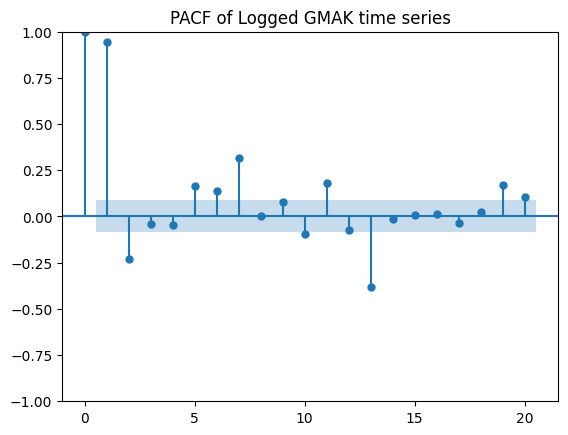

In [7]:
#plot the pacf for the original data
#we can see that the partial autocorrelation for the first lag is close to one, while the rest are close to zero, indicating that the data is not stationary.
#thus our methods of differencing and taking the log have made the data stationary.
plot_pacf(gmak_log, title='PACF of Logged GMAK time series', lags=20)

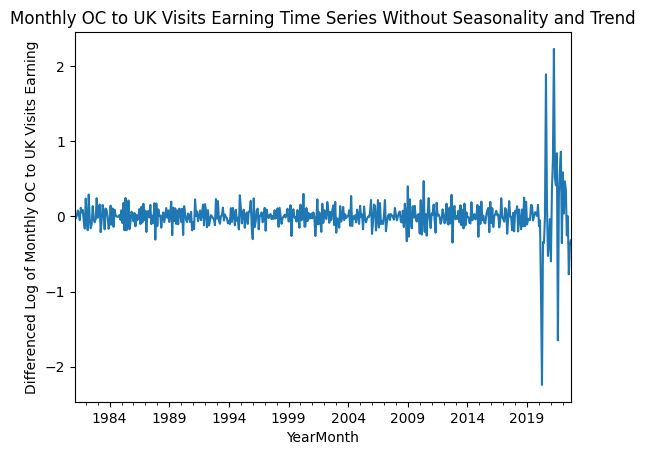

ADF Statistic: -7.238760
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


In [8]:
# 2.3.1 model selection
#how to determine p ,d, q
#remove trend
gmak_trend = gmak_log.diff(periods=1)
#remove seasonality
gmak_diff = gmak_trend.diff(periods=12)
gmak_diff.dropna(inplace=True)
gmak_diff.plot()
plt.title('Monthly OC to UK Visits Earning Time Series Without Seasonality and Trend')
plt.ylabel('Differenced Log of Monthly OC to UK Visits Earning')
plt.show()

#after differencing, we can see that the distribution becomes normal and thus the data is stationary. We can now determine model parameters with PACF and ACF plots
#test if the data is stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(gmak_diff.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
#the p-value is less than 0.05, so we can reject the null hypothesis that the data is not stationary. Thus the data is stationary.

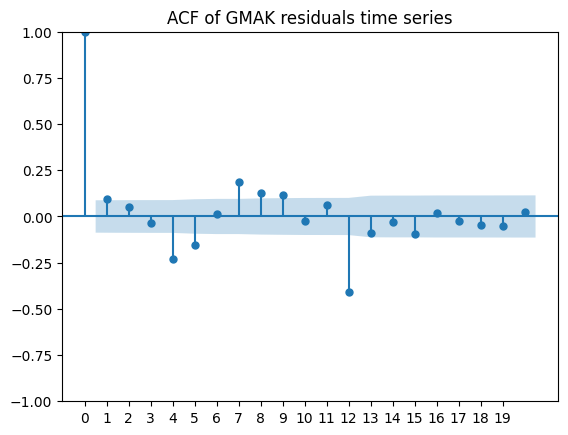

In [9]:
#2.3.1

#check for autocorrelation and partial autocorrelation on the remained data
plot_acf(gmak_diff, title='ACF of GMAK residuals time series', lags=20)
#set the x axis to be the index of the data
plt.xticks(np.arange(0, 20, step=1))
plt.show()

/Users/zhengzeng/.pyenv/versions/3.9.4/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


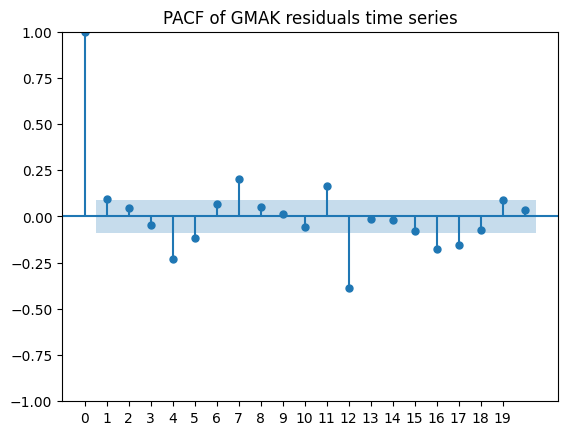

In [10]:
#2.3.1
#from the pacf plot we can see that the first lag is highly partial correlated, and thus for the autoregressive model, we can set p=1
plot_pacf(gmak_diff, title='PACF of GMAK residuals time series', lags=20)
plt.xticks(np.arange(0, 20, step=1))
plt.show()

In [11]:
#2.3.2 model testing 
#reate an ARIMA(p,q,d) model
#p for AR - from pacf plot, we can see that the first lag is highly correlated, so we can use p=1
#q for MA - from acf plot, we can see that for no lag it has high correlation, so we can use q=0
#d for differencing - we get the stationary data after two first-order differencing, so we can use d=1

model = sm.tsa.statespace.SARIMAX(gmak_log, order=(1,1,), seasonal_order=(0,1,1,12))
result = model.fit(disp = False)
print(result.summary())

# Ljung-Box test has a result of 0.00. The probabiliy for Q is 0.95,
# Thus so we can reject the null hypothesis that the residuals are not white noise. The 
# the model is : Yt+1 = Yt+ Yt-12 +Et+1+ sigma
#the coefficients shows that:
# - AR(1) are all highly significant at a significance level of 0.1
# - seasonality of s = 12 is significant at a significance level of 0.1

ValueError: Invalid model: moving average lag(s) {12} are in both the seasonal and non-seasonal moving average components.

In [45]:
#increase model parameters to see if we can get a better model
model2 = sm.tsa.statespace.SARIMAX(gmak_log, order=(2,1,1), seasonal_order=(0,1,1,12))
result2 = model2.fit(disp = False)
print(result2.summary())

#we can see that the Q statistics is close to 0, with a prob of 0.96, meaning the residuals are white noise, and the model is a good fit but not necessary the better than before, because:
# - the JB test results in a prob of 0.96, similar to the previous model
# - AIC and BIC values are slightly smaller
# - it takes more variables to explain the data but the goodness of fit is not necessarily better.



/Users/zhengzeng/.pyenv/versions/3.9.4/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zhengzeng/.pyenv/versions/3.9.4/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zhengzeng/.pyenv/versions/3.9.4/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                     SARIMAX Results                                      
Dep. Variable:                               GMAK   No. Observations:                  513
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 118.169
Date:                            Tue, 14 Mar 2023   AIC                           -226.338
Time:                                    23:45:22   BIC                           -205.265
Sample:                                01-01-1980   HQIC                          -218.069
                                     - 09-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8071      0.091     -8.823      0.000      -0.986      -0.628
ar.L2          0.0250      0.025   

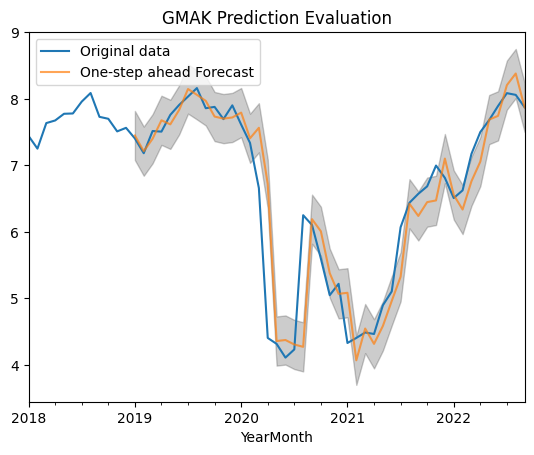

the rmse of the prediction model is 0.54117


In [48]:
#2.3.3 model evaluation
#use the original model to predict the last three years and compare them with the original data
pred = result.get_prediction(start = pd.to_datetime('2019-01-01'),dynamic = False)
# print(pred.predicted_mean)
pred_ci = pred.conf_int()

ax = gmak_log['2018':].plot(label='Original data')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('GMAK Prediction Evaluation')
plt.legend()
plt.show()
#calculate the RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(gmak_log['2019-01-01':], pred.predicted_mean))
print("the rmse of the prediction model is %0.5f" % rmse)
#the prediction error is very small, which means the model is a good fit

            lower GMAK    upper GMAK         mean
2023-03-01  629.983258   4369.821516  1659.190886
2023-04-01  531.906858   4326.759531  1517.047483
2023-05-01  576.153575   5434.479500  1769.489981
2023-06-01  582.299021   6310.618428  1916.942078
2023-07-01  727.789551   8993.157309  2558.344370
2023-08-01  888.852570  12441.911677  3325.511264
2023-09-01  710.298091  11199.621859  2820.473370
2023-10-01  587.914506  10678.961988  2505.656932
2023-11-01  466.163358   9711.133653  2127.668836
2023-12-01  450.662529  10705.249461  2196.464157


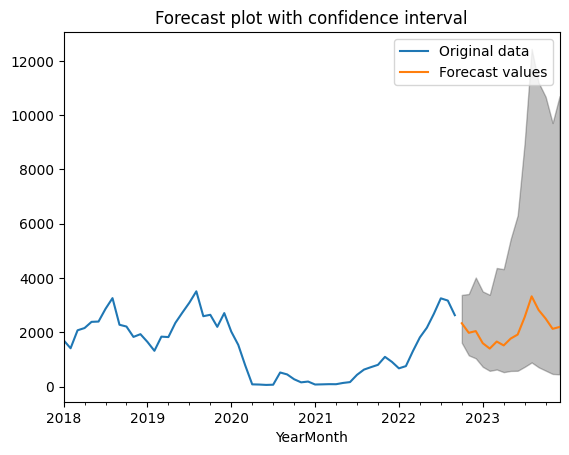

In [49]:
#predict to the future of 2023-12
pred_uc = result.get_forecast(steps=15)
# Get confidence intervals of forecasts

pred_ci =pred_uc.conf_int()
#cast it into exponential form
pred_ci = np.exp(pred_ci)
pred_ci['mean'] = np.exp(pred_uc.predicted_mean)
print(pred_ci.tail(10))

# plotting forecasts ahead
ax = gmak['2018':].plot(label='Original data')
pred_ci['mean'].plot(ax=ax, label='Forecast values', title='Forecast plot with confidence interval')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.legend()
plt.show()
#the predicion seems to show that there may be an OC to UK visits surge in the future, but the future is volatile.